<a href="https://colab.research.google.com/github/mr-nastik/UrbanSound8k/blob/main/UrabanSound8K_midsem_extend_minpool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH='/content/gdrive/My Drive/urbansound8k/'


In [ ]:
!ls

gdrive	sample_data


In [ ]:
!pip install soundfile

In [ ]:
!pip install livelossplot

In [ ]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input,TimeDistributed,LSTM
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from livelossplot import PlotLossesKeras

#for data handaling
import os
from tqdm.auto import tqdm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#for calc accuaracy and spliting the data
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline

#for sound
import librosa
import librosa.display
import glob 
import skimage
import soundfile as sf
from scipy.io.wavfile import read

In [ ]:
df=pd.read_csv(PATH+'UrbanSound8K.csv')
print(df.head())
print(df.tail())
print("shape of train.csv: ",df.shape)

      slice_file_name    fsID  start  ...  fold  classID             class
0    100032-3-0-0.wav  100032    0.0  ...     5        3          dog_bark
1  100263-2-0-117.wav  100263   58.5  ...     5        2  children_playing
2  100263-2-0-121.wav  100263   60.5  ...     5        2  children_playing
3  100263-2-0-126.wav  100263   63.0  ...     5        2  children_playing
4  100263-2-0-137.wav  100263   68.5  ...     5        2  children_playing

[5 rows x 8 columns]
      slice_file_name   fsID       start  ...  fold  classID     class
8727  99812-1-2-0.wav  99812  159.522205  ...     7        1  car_horn
8728  99812-1-3-0.wav  99812  181.142431  ...     7        1  car_horn
8729  99812-1-4-0.wav  99812  242.691902  ...     7        1  car_horn
8730  99812-1-5-0.wav  99812  253.209850  ...     7        1  car_horn
8731  99812-1-6-0.wav  99812  332.289233  ...     7        1  car_horn

[5 rows x 8 columns]
shape of train.csv:  (8732, 8)


In [ ]:
type(df['class'][0])

str

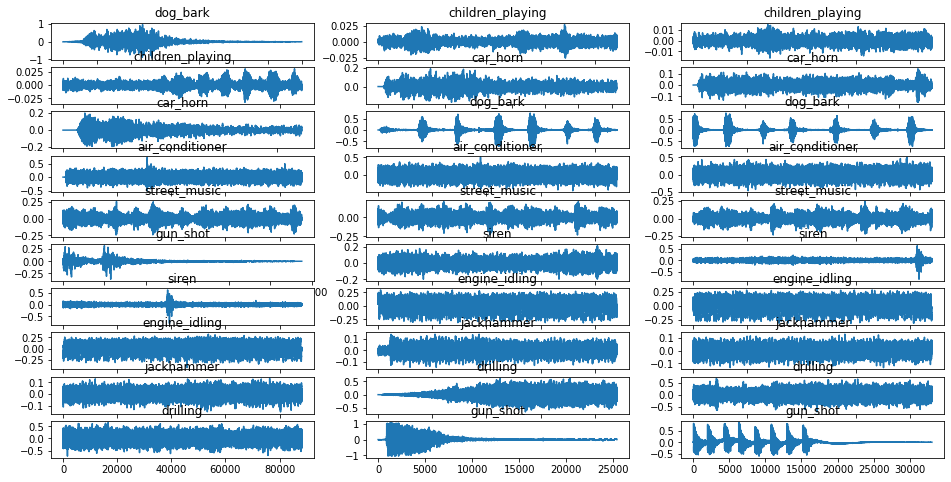

In [ ]:
f, ax = plt.subplots(10, 3, figsize=(16, 8))
ax = ax.flatten()
a=[0,0 ,0, 0 ,0 ,0 ,0 ,0 ,0 ,0]
k=0
i=0
while(i<30):
    if a[df['classID'][k]]>=3:
        k+=1
        continue
    a[df['classID'][k]]+=1
    sound,sr=librosa.load(PATH+'fold'+str(df['fold'][k])+'/'+df['slice_file_name'][k],res_type='kaiser_fast')
    ax[i].set_title(df['class'][k])
    ax[i].plot(sound)
    i+=1
    k+=1

(40, 200)
(40, 200)
(40, 200)
(40, 200)
(40, 200)
(40, 200)
(40, 200)
(40, 200)
(40, 200)
(40, 200)


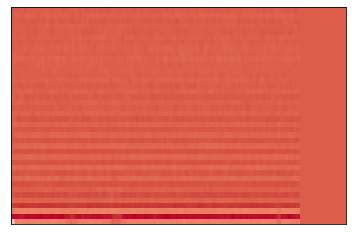

In [ ]:
#f, ax = plt.subplots(10, 3, figsize=(16, 8))
#ax = ax.flatten()
a=[0,0 ,0, 0 ,0 ,0 ,0 ,0 ,0 ,0]
k=0
i=0
while(i<10):
    if a[df['classID'][k]]>=3:
        k+=1
        continue
    a[df['classID'][k]]+=1
    sound,sr=librosa.load(PATH+'fold'+str(df['fold'][k])+'/'+df['slice_file_name'][k],res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(sound, sr=sr,n_mfcc=40)
    mfccs=np.pad(mfccs, pad_width=((0, 0), (0, 200- mfccs.shape[1])), mode='constant')
    print(mfccs.shape)
    #ax[i].set_title(df['class'][k])
    librosa.display.specshow(mfccs, sr=sr)
    i+=1
    k+=1

In [ ]:
mfccs.shape

(40, 200)

In [ ]:
def plot_count(feature, title, df, size=1):
    '''
    Plot count of classes of selected feature; feature is a categorical value
    param: feature - the feature for which we present the distribution of classes
    param: title - title to show in the plot
    param: df - dataframe 
    param: size - size (from 1 to n), multiplied with 4 - size of plot
    '''
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:30], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.savefig('freq of '+feature+'.png', dpi=300, bbox_inches='tight')
    plt.show()


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


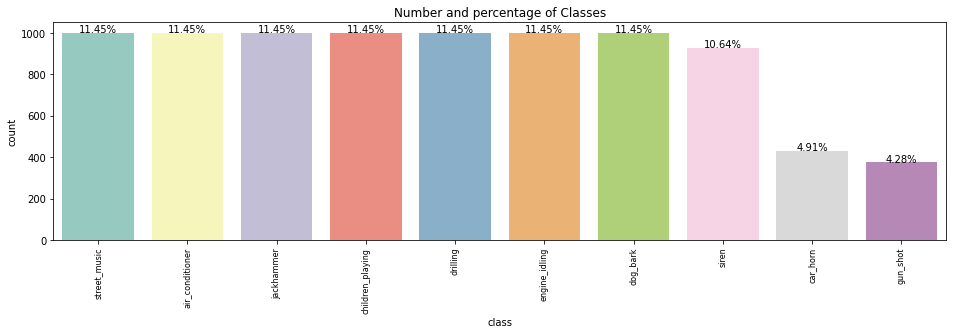

In [ ]:
plot_count('class', 'Classes', df, size=4)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


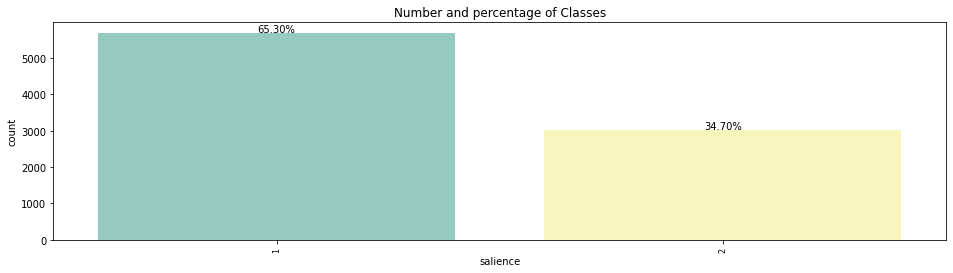

In [ ]:
plot_count('salience', 'Classes', df, size=4)

In [ ]:
X=[]
Y=[]
for i in tqdm(range(8732)):
    data,sr=librosa.load(PATH+'fold'+str(df['fold'][i])+'/'+df['slice_file_name'][i],res_type='kaiser_fast')
    data=librosa.feature.mfcc(y=data,sr=sr,n_mfcc=60)
    data=np.pad(data, pad_width=((0, 0), (0, 200- data.shape[1])), mode='constant')
    X.append(data)
    Y.append(df['classID'][i])


/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In [ ]:
X[3].shape

(60, 200)

In [ ]:
X=np.asarray(X)
Y=np.array(Y)
Y=keras.utils.to_categorical(Y)
X.shape
Y.shape

(8732, 10)

In [ ]:
print(X.shape)

(8732, 60, 200)


In [ ]:
np.save(PATH+'mfcc_CNN_60_ks_X.npy',X)


In [ ]:
np.save(PATH+'mfcc_CNN_60_ks_Y.npy',Y)


In [ ]:
X=np.load(PATH+'mfcc_CNN_60_ks_4s_X.npy')
Y=np.load(PATH+'mfcc_CNN_60_ks_4s_Y.npy')

In [ ]:
print(X.shape,Y.shape)

(8732, 60, 173) (8732, 10)


In [ ]:
X=X.reshape(-1,1,60,173,1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=13)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=13)

In [ ]:
print(x_train.shape,
y_train.shape,
x_val.shape,
y_val.shape,
x_test.shape,
y_test.shape)

(5238, 1, 60, 173, 1) (5238, 10) (1747, 1, 60, 173, 1) (1747, 10) (1747, 1, 60, 173, 1) (1747, 10)


In [ ]:
inputs= Input(shape=(1,60,173,1))
model=TimeDistributed(Conv2D(filters=32,kernel_size=(5,5),padding='SAME',activation='relu'))(inputs)
model=TimeDistributed(BatchNormalization(momentum=0.2))(model)
model=TimeDistributed(Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu'))(model)
model=TimeDistributed(Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu'))(model)
model=TimeDistributed(Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu'))(model)
model=TimeDistributed(Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu'))(model)
model=-model
model=TimeDistributed(MaxPooling2D(pool_size=(2,2)))(model)
model=-model

model=TimeDistributed(Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu'))(model)
model=TimeDistributed(Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu'))(model)
model=TimeDistributed(Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu'))(model)
model=-model
model=TimeDistributed(MaxPooling2D(pool_size=(2,2)))(model)
model=-model

model=TimeDistributed(Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu'))(model)
model=TimeDistributed(Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu'))(model)
model=-model
model=TimeDistributed(MaxPooling2D(pool_size=(2,2)))(model)
model=-model

model=TimeDistributed(Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu'))(model)
model=TimeDistributed(BatchNormalization(momentum=0.2))(model)
model=-model
model=TimeDistributed(MaxPooling2D(pool_size=(2,2)))(model)
model=-model

model=TimeDistributed(Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu'))(model)
model=-model
model=TimeDistributed(MaxPooling2D(pool_size=(2,2)))(model)
model=-model

model=TimeDistributed(Flatten())(model)
model=LSTM(64,return_sequences=True)(model)


#model=Dense(1024,activation='relu')(model)
#model=BatchNormalization(momentum=0.2)(model)
#model=Dense(512,activation='relu')(model)
#model=BatchNormalization(momentum=0.2)(model)
model=Flatten()(model)
output=Dense(10,activation='softmax',name='output')(model)

model=Model(inputs=inputs,outputs=[output])

In [ ]:
model.summary()
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
mcp_save = ModelCheckpoint(PATH+'MinPooling4sLSTM.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-5, mode='min')

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1, 60, 173, 1)]   0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 1, 60, 173, 32)    832       
_________________________________________________________________
time_distributed_27 (TimeDis (None, 1, 60, 173, 32)    128       
_________________________________________________________________
time_distributed_28 (TimeDis (None, 1, 60, 173, 32)    9248      
_________________________________________________________________
time_distributed_29 (TimeDis (None, 1, 60, 173, 32)    9248      
_________________________________________________________________
time_distributed_30 (TimeDis (None, 1, 60, 173, 32)    9248      
_________________________________________________________________
time_distributed_31 (TimeDis (None, 1, 60, 173, 32)    9248

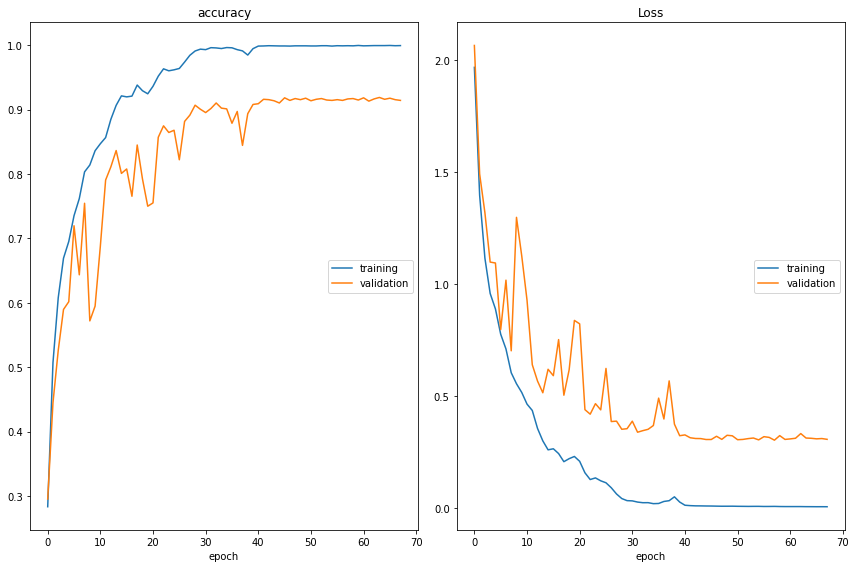

accuracy
	training         	 (min:    0.283, max:    0.999, cur:    0.999)
	validation       	 (min:    0.295, max:    0.919, cur:    0.914)
Loss
	training         	 (min:    0.005, max:    1.969, cur:    0.005)
	validation       	 (min:    0.303, max:    2.067, cur:    0.306)
Epoch 00068: early stopping


In [ ]:
model.fit(x_train, y_train,
          batch_size=256,
          epochs=200,
          callbacks=[PlotLossesKeras(), earlyStopping, mcp_save, reduce_lr_loss],
          verbose=1,
          validation_data=(x_val, y_val))

In [ ]:
score = model.evaluate(x_test, y_test)
print(score)

55/55 [==============================] - 1s 21ms/step - loss: 0.2876 - accuracy: 0.9262
[0.287584513425827, 0.926159143447876]


In [ ]:
model.load_weights(PATH+'MinPooling4sLSTM.hdf5')
score = model.evaluate(x_test, y_test)
print(score)

55/55 [==============================] - 1s 22ms/step - loss: 0.2854 - accuracy: 0.9267
[0.28535327315330505, 0.926731526851654]
